<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/Top_ten_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

url  = [ #
    #ibra50
    'https://raw.githubusercontent.com/BDonadelli/Finance-playground/main/data/Cart_IBr50.csv',
    #ibra100
    'https://raw.githubusercontent.com/BDonadelli/Finance-playground/main/data/Cart_IBr100.csv',
    #div
    'https://raw.githubusercontent.com/BDonadelli/Finance-playground/main/data/Cart_Idiv.csv' ,
    #small
    'https://raw.githubusercontent.com/BDonadelli/Finance-playground/main/data/Cart_Small.csv',
    #ibbr
    'https://raw.githubusercontent.com/BDonadelli/Finance-playground/main/data/Cart_IBBR.csv',
    #low vol
    'https://raw.githubusercontent.com/BDonadelli/Finance-playground/main/data/Cart_Ibov_LowVol.csv'
]

escolha = int(input('0-ibra50; 1-ibra100; 2-idiv; 3-small; 4- ibbr ; 5-low vol: '))
indice = { 0:'Ibra50' , 1:'Ibra100' , 2:'Idiv' , 3:'Small' , 4:'IBBr' , 5:'Low Vol'}
# if escolha == 4 :
#     df = pd.read_csv(url[escolha] ,sep=',' , decimal='.' , 
#               index_col=False , engine='python')
# else:   
df = pd.read_csv(url[escolha] ,sep=';' , decimal=',' , thousands='.' , 
                header=1 , skiprows=0 , skipfooter=2 , encoding='latin-1',index_col=False , engine='python')

data = yf.download((df['Código']+'.SA').to_list(),
                         period="max",
                         interval="1d",
                         auto_adjust=True,
                         back_adjust=True,
                         prepost=True)['Close']

bench = yf.download(['BOVA11.SA', 'SMAL11.SA' , 'DIVO11.SA'],
                         period="max",
                         interval="1d",
                         auto_adjust=True,
                         back_adjust=True,
                         prepost=True)['Close']

[*********************100%%**********************]  91 of 91 completed
[*********************100%%**********************]  3 of 3 completed


In [3]:
print(indice[escolha])
df

IBBr


,Código,Ação,Tipo,Qtde. Teórica,Part. (%)
0,ALOS3,ALLOS,ON NM,555485176,0.478
1,ALPA4,ALPARGATAS,PN N1,173505007,0.047
2,ABEV3,AMBEV S/A,ON,4582918494,2.253
3,ASAI3,ASSAI,ON NM,1407148303,0.489
4,AURE3,AUREN,ON NM,314931632,0.132
...,...,...,...,...,...
86,VBBR3,VIBRA,ON NM,1162471086,1.136
87,VIVA3,VIVARA S.A.,ON NM,131318220,0.135
88,WEGE3,WEG,ON NM,1202860110,2.366
89,XPBR31,XP INC,DR1,455485738,1.724


Os 10 melhores momentum no ultimo periodo

          % change              sector
Ticker                                
IRBR3.SA     50.96  Financial Services
LREN3.SA     39.96   Consumer Cyclical
VIVA3.SA     39.26   Consumer Cyclical
MRFG3.SA     37.45  Consumer Defensive
WEGE3.SA     37.14         Industrials
PETZ3.SA     33.43   Consumer Cyclical
BRFS3.SA     32.21  Consumer Defensive
EMBR3.SA     30.19         Industrials
BBDC3.SA     29.84  Financial Services
SBSP3.SA     28.33           Utilities
VBBR3.SA     27.61   Consumer Cyclical
BBDC4.SA     27.56  Financial Services


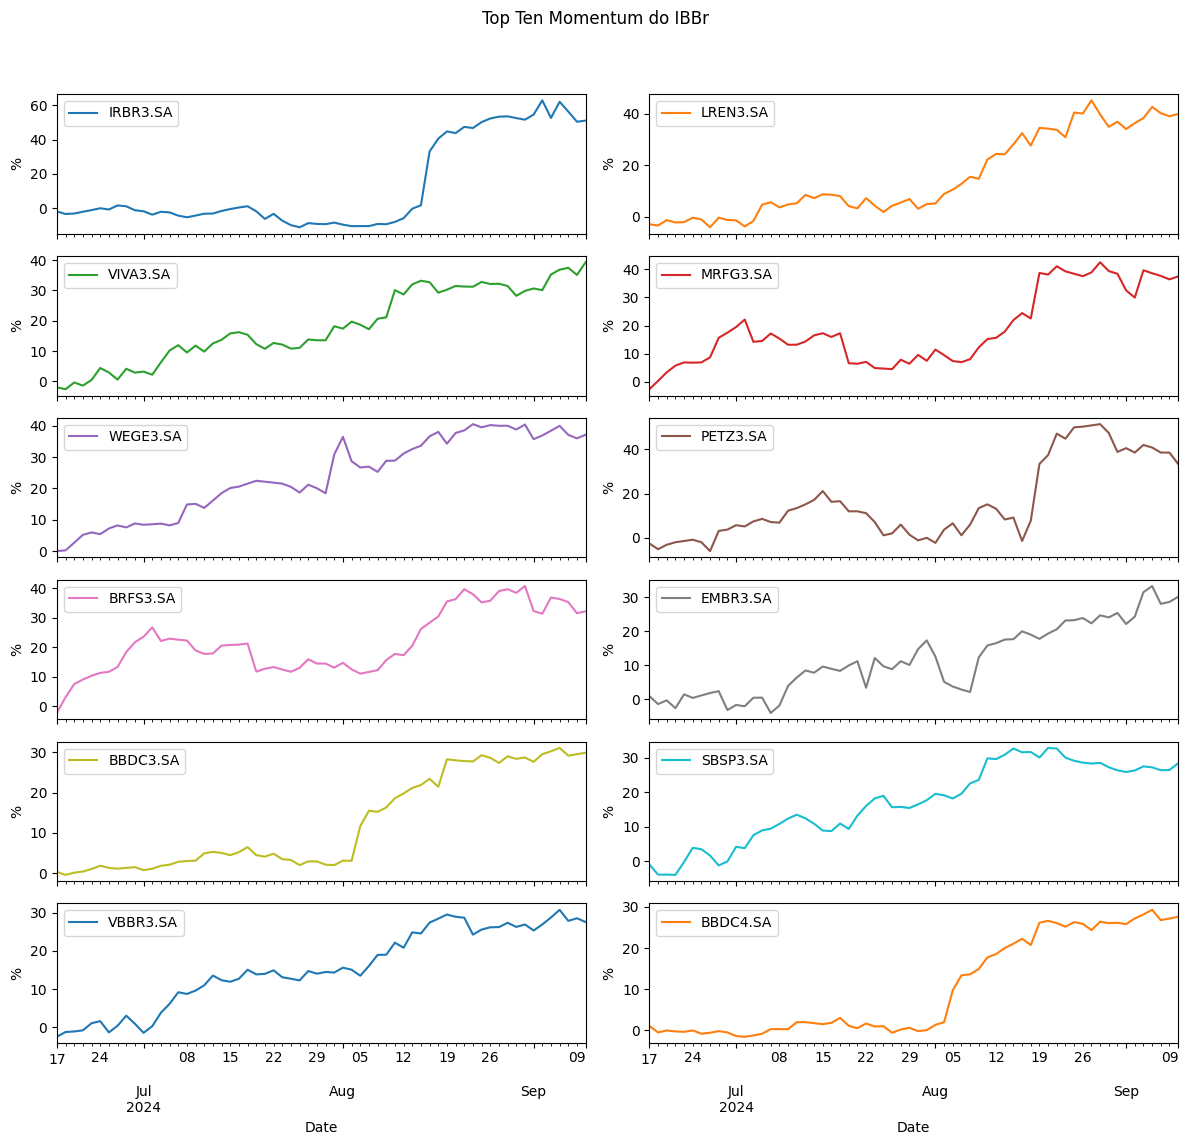

In [19]:
periodo = 62 # dias

daily_returns = data.pct_change(fill_method=None)
# print(daily_returns )

# ## remover ações que esticaram muito
# print(daily_returns.shape)
# # growth theshold
# threshold = 0.04
# # keep only the columns without a daily growth that big
# daily_returns = daily_returns.loc[:, ~(daily_returns >= threshold).any()]
# print(daily_returns.shape)

cum_returns = (1 + daily_returns[-periodo:]).cumprod() -1
# print(cum_returns.tail(2))
# last row, transpose, x100
latest = cum_returns.tail(1).T.mul(100)
latest.columns = ['% change']
topten = round(latest.sort_values(by='% change', ascending=False)[:12], 2)
# print(topten)

topten_info = {}
for i in topten.index:
    topten_info[i] = yf.Ticker(i).get_info()
#info_df = pd.DataFrame.from_dict(topten_info,orient='index')
topten = topten.join(info_df['sector'])
print(topten)

cum_returns[list(topten.index)].mul(100).plot(subplots=True,
                                          layout=(6, 2),
                                          figsize=(12,12),
                                          sharex=True,
                                          ylabel='%',
                                          title=f'Top Ten Momentum do {indice[escolha]}')
# tweek the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [20]:
info_df['sector'].value_counts()

sector
Consumer Cyclical     4
Financial Services    3
Consumer Defensive    2
Industrials           2
Utilities             1
Name: count, dtype: int64

### estratégia

todo mes compra as n de melhor momentum passado

In [51]:
def rolling_ret( df , m=1):
  '''
    df : dataframe com retornos 
    calcula retorno acumulado na janela de m periodos
  '''
  return (df+1).rolling(m).apply(np.prod) - 1 

def get_top( df , date , n=10):
  '''
    lista das colunas de df com os n maiores valores na data 'date'
  '''
  return df.loc[date].nlargest(n).index.to_list()

def port_ret(df , date ,  port = None):
  '''
    calcula a média aritmetica dos retornos (df) 
    da carteira (port) na 1a data a partir da data (date) 
  '''
  if port is None : port = get_top(df , date ,n = 5 )

  return df.loc[date:,port].mean(axis=1).values[0]

In [49]:
monthly_returns =  data.resample('M').last().pct_change(fill_method=None)
bench_returns = bench.resample('M').last().pct_change(fill_method=None)
monthly_returns - rolling_ret(monthly_returns,1) 

Ticker,ABEV3.SA,ALOS3.SA,ALPA4.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,AZZA3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VAMO3.SA,VBBR3.SA,VIVA3.SA,VIVT3.SA,WEGE3.SA,XPBR31.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2000-03-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2000-04-30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2000-05-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
get_top(monthly_returns , date='2024-08-31' , n=5)

['IRBR3.SA', 'PETZ3.SA', 'LREN3.SA', 'MRFG3.SA', 'BBDC3.SA']

In [59]:
port_ret( rolling_ret(monthly_returns,1) , # retorno mensal
         '2024-08-31' ,  # no fim de agosto
         get_top(monthly_returns , '2024-08-31' , 5) # das 5 melhores
         )

0.37845571923848864

In [60]:
monthly_returns.loc['2024-08-31'].nlargest(5)

Ticker
IRBR3.SA    0.650631
PETZ3.SA    0.388571
LREN3.SA    0.304676
MRFG3.SA    0.287356
BBDC3.SA    0.261044
Name: 2024-08-31 00:00:00, dtype: float64

##### momentum

In [62]:
janela = 3   # meses
tam_carteira = 5 # papeis

In [63]:
mom = rolling_ret(monthly_returns,janela)
mom.tail()

Ticker,ABEV3.SA,ALOS3.SA,ALPA4.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,AZZA3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VAMO3.SA,VBBR3.SA,VIVA3.SA,VIVT3.SA,WEGE3.SA,XPBR31.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-31,-0.081081,-0.102555,-0.049164,-0.142253,-0.039469,-0.216708,-0.165963,-0.162325,-0.055800,-0.065227,...,-0.199794,-0.292584,-0.014374,-0.071019,-0.145592,-0.322338,-0.184090,0.024929,-0.146206,-0.394564
2024-06-30,-0.086469,-0.067040,-0.043022,-0.297077,0.036975,-0.437117,-0.201027,-0.138969,-0.033155,-0.089263,...,-0.241307,-0.182536,0.022851,-0.093413,-0.142803,-0.161994,-0.078018,0.104450,-0.236534,-0.414894
2024-07-31,-0.046914,0.105230,-0.090909,-0.251524,0.025022,-0.179487,-0.053459,0.013786,-0.007753,-0.057737,...,-0.140812,-0.213654,-0.026228,0.213783,0.009768,0.085289,0.035489,0.282819,-0.080977,-0.250171
2024-08-31,0.112457,0.087744,-0.203723,-0.214286,-0.046064,-0.430834,0.001983,0.194741,0.080099,0.280885,...,0.018926,-0.177015,-0.022840,-0.062885,0.221339,0.211927,0.215234,0.449683,0.042084,-0.186623
2024-09-30,0.160386,0.086648,-0.212719,-0.139265,-0.096434,-0.425068,-0.063805,0.214844,0.092253,0.278954,...,0.069592,-0.270544,-0.067089,-0.023778,0.265101,0.353391,0.214631,0.260227,0.040286,-0.067243


In [64]:
date = mom.index[-1].date().strftime("%Y-%m-%d")
prox = mom.loc[date].nlargest(tam_carteira).index.values
print(f'proxima carteira: {prox} data de referencia {date}')

proxima carteira: ['IRBR3.SA' 'LREN3.SA' 'VIVA3.SA' 'EMBR3.SA' 'PETZ3.SA'] data de referencia 2024-09-30


carteiras com melhor momentum

In [66]:
carteiras = []
for date in mom.index:
    # print(date.date() , get_top( ret , date , tam_carteira), port_ret( data , date ,  get_top( ret , date) ))
    carteiras.append(get_top( mom , date , tam_carteira))

In [68]:
carteiras[-5:]

[['EMBR3.SA', 'JBSS3.SA', 'BRFS3.SA', 'CMIG4.SA', 'MRFG3.SA'],
 ['JBSS3.SA', 'BRFS3.SA', 'ROXO34.SA', 'INBR32.SA', 'MRFG3.SA'],
 ['JBSS3.SA', 'INBR32.SA', 'EMBR3.SA', 'WEGE3.SA', 'BRFS3.SA'],
 ['IRBR3.SA', 'WEGE3.SA', 'BRFS3.SA', 'ROXO34.SA', 'LREN3.SA'],
 ['IRBR3.SA', 'LREN3.SA', 'VIVA3.SA', 'EMBR3.SA', 'PETZ3.SA']]

retorno da estrategia

In [69]:
# a carteira roda no mes seguinte
retornos = [0.0]
for i in range(1,len(monthly_returns)): 
  print(monthly_returns.index[i].date() , carteiras[i-1] , port_ret( monthly_returns  , monthly_returns.index[i] , carteiras[i-1] ))
  retornos.append(port_ret( monthly_returns , monthly_returns.index[i] , carteiras[i-1] ))

2000-02-29 ['ABEV3.SA', 'ALOS3.SA', 'ALPA4.SA', 'ASAI3.SA', 'AURE3.SA'] -0.06584870252274411
2000-03-31 ['ABEV3.SA', 'ALOS3.SA', 'ALPA4.SA', 'ASAI3.SA', 'AURE3.SA'] 0.29582626805382084
2000-04-30 ['ABEV3.SA', 'ALOS3.SA', 'ALPA4.SA', 'ASAI3.SA', 'AURE3.SA'] 0.03260502385963959
2000-05-31 ['CPFE3.SA', 'TRPL4.SA', 'ABEV3.SA', 'PETR3.SA', 'EMBR3.SA'] -0.014059145700694243
2000-06-30 ['GGBR4.SA', 'CPFE3.SA', 'ABEV3.SA', 'LREN3.SA', 'CSNA3.SA'] 0.013217549623172365
2000-07-31 ['RADL3.SA', 'GGBR4.SA', 'CPFE3.SA', 'PETR3.SA', 'ABEV3.SA'] 0.03130488165803689
2000-08-31 ['RADL3.SA', 'GGBR4.SA', 'ELET3.SA', 'ABEV3.SA', 'BRKM5.SA'] 0.008582102786130563
2000-09-30 ['RADL3.SA', 'ABEV3.SA', 'PETR3.SA', 'SBSP3.SA', 'EMBR3.SA'] 0.0035563538487509037
2000-10-31 ['ABEV3.SA', 'SBSP3.SA', 'USIM5.SA', 'WEGE3.SA', 'EMBR3.SA'] -0.0005811704587261879
2000-11-30 ['ABEV3.SA', 'WEGE3.SA', 'PETR3.SA', 'CPFE3.SA', 'EMBR3.SA'] -0.02967963290485003
2000-12-31 ['ABEV3.SA', 'BBDC3.SA', 'WEGE3.SA', 'BRFS3.SA', 'CPFE3.SA

In [93]:
compara = pd.DataFrame({'carteira' : retornos , 'benchmark' : bench_returns['DIVO11.SA']} , index=monthly_returns.index)
compara = compara[-60:-1]
compara.iloc[0]=[0,0]
compara

,carteira,benchmark
Date,,
2019-10-31,0.000000,0.000000
2019-11-30,0.037455,0.023282
2019-12-31,0.140440,0.105808
2020-01-31,0.122700,-0.021583
2020-02-29,-0.087557,-0.064706
2020-03-31,-0.408200,-0.255031
2020-04-30,0.059213,0.052132
2020-05-31,0.030575,0.049950
2020-06-30,0.149376,0.085212


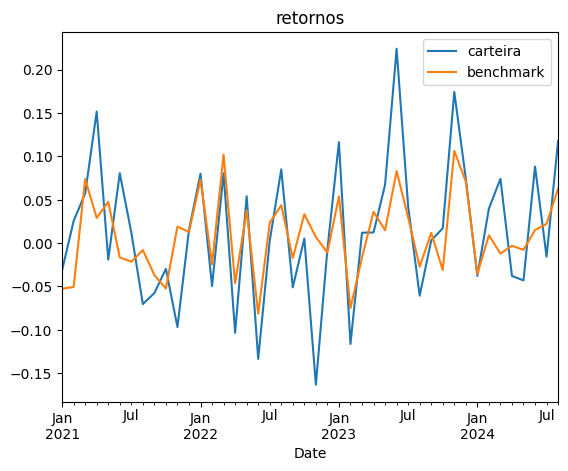

In [94]:
compara.loc['2021-01-01':].plot(title='retornos');

In [95]:
compara['bench_acum'] = (compara.benchmark+1.0).cumprod()
compara['carteira_acum'] = (compara.carteira+1.0).cumprod()
compara.tail()

,carteira,benchmark,bench_acum,carteira_acum
Date,,,,
2024-04-30,-0.037994,-0.003160,1.437968,1.987555
2024-05-31,-0.043087,-0.007926,1.426571,1.901918
2024-06-30,0.088196,0.014951,1.447900,2.069660
2024-07-31,-0.015735,0.022152,1.479974,2.037093
2024-08-31,0.117831,0.062706,1.572778,2.277126


<Axes: title={'center': 'retornos acumulados'}, xlabel='Date'>

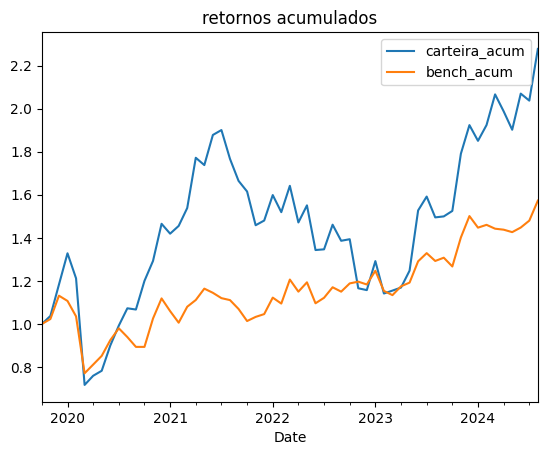

In [96]:
compara[['carteira_acum','bench_acum']].plot(title='retornos acumulados')